In [5]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.cnn import cnn_4layer
from model.mlp import mlp_layer

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
import random

random.seed(10)
print(random.random())

0.5714025946899135


In [8]:
# https://keras.io/examples/timeseries/timeseries_weather_forecasting/#climate-data-timeseries
data = pd.read_csv("../../data/jena_climate_2009_2016_hourly.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333


In [9]:
data.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [10]:
# plt.hist(data['pollution'], bins=20)

### Preprocess

In [13]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (70046, 1176)


In [14]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 5
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (49032, 1008) (49032, 12) (10507, 1008) (10507, 12) (10507, 1008) (10507, 12)


In [15]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (49032, 72, 14) (49032, 12) (10507, 72, 14) (10507, 12) (10507, 72, 14) (10507, 12)


### PM threshold

In [16]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(49032,)
(10507,)
(10507,)


In [17]:
percentile = 95

merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

95th Percentile of Daily Rain: 0.48441203148316114


### train_X_filter

In [18]:
train_X_extreme = train_X[train_X_pm > percentile_pm]
print(train_X_extreme.shape)

train_y_extreme = train_y[train_X_pm > percentile_pm]
print(train_y_extreme.shape)

(2206, 72, 14)
(2206, 12)


In [19]:
train_X_normal = train_X[train_X_pm <= percentile_pm]
print(train_X_normal.shape)

train_y_normal = train_y[train_X_pm <= percentile_pm]
print(train_y_normal.shape)

(46826, 72, 14)
(46826, 12)


### val_X_filter

In [20]:
val_X_extreme = val_X[val_X_pm > percentile_pm]
print(val_X_extreme.shape)

val_y_extreme = val_y[val_X_pm > percentile_pm]
print(val_y_extreme.shape)

(486, 72, 14)
(486, 12)


In [21]:
val_X_normal = val_X[val_X_pm <= percentile_pm]
print(val_X_normal.shape)

val_y_normal = val_y[val_X_pm <= percentile_pm]
print(val_y_normal.shape)

(10021, 72, 14)
(10021, 12)


### test_X_filter

In [22]:
test_X_extreme = test_X[test_X_pm > percentile_pm]
print(test_X_extreme.shape)

test_y_extreme = test_y[test_X_pm > percentile_pm]
print(test_y_extreme.shape)

(811, 72, 14)
(811, 12)


In [23]:
test_X_normal = test_X[test_X_pm <= percentile_pm]
print(test_X_normal.shape)

test_y_normal = test_y[test_X_pm <= percentile_pm]
print(test_y_normal.shape)

(9696, 72, 14)
(9696, 12)


In [24]:
# Load your dataset
D_f, y_f = train_X, train_y                # Training data (includes both X_rain and X_norm)
# D_g, y_g = val_X_extreme, val_y_extreme   

D_g, y_g = np.concatenate((val_X_extreme, test_X_extreme)), np.concatenate((val_y_extreme, test_y_extreme))

In [25]:
D_f.shape

(49032, 72, 14)

### Model

In [26]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0  # 0.1
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [28]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )

In [29]:
# Define the forward function for the model
def forward(model, X, y, weights):
    predictions = model(X, training=True)
    loss = tf.reduce_mean(tf.losses.mean_squared_error(y, predictions) * weights)
    return loss, predictions


def backward(loss):
    # Compute gradients of loss with respect to model parameters
    gradients = tf.gradients(loss, model.trainable_variables)
    return gradients



# Assuming model, D_f, y_f, example_weights, etc. are defined

# Define the loss function
def calculate_loss(model, X, y, weights):
    predictions = model(X)
    individual_losses = tf.losses.mean_squared_error(y, predictions)  # This gives a loss per sample
    weighted_losses = individual_losses * weights
    return tf.reduce_mean(weighted_losses), individual_losses

In [32]:
# # Define the optimizer for the primary model
# optimizer = Adam(learning_rate=0.01)

# Initialize the example weights wi with ones
# example_weights = tf.ones(shape=(len(D_f)))

sample_weights_IPF = np.load('sample_weights_pressure_IPF.npy')
example_weights = tf.convert_to_tensor(sample_weights_IPF, dtype=tf.float32)


# Batch size
batch_size = 64

In [33]:
# Training loop
for t in range(100):  # Number of iterations
    # Shuffle the training data and example weights at the beginning of each epoch
    indices = np.arange(len(D_f))
    #np.random.shuffle(indices)
    D_f_shuffled = tf.gather(D_f, indices)
    y_f_shuffled = tf.gather(y_f, indices)

    
    example_weights_shuffled = tf.gather(example_weights, indices)
    #print("example_weights_shuffled:", example_weights_shuffled.numpy()[:10])
    
    
    # Convert example_weights_shuffled back to a tf.Variable if it's not one after tf.gather
    example_weights_shuffled = tf.Variable(example_weights_shuffled)
    #print("example_weights_shuffled:", example_weights_shuffled.numpy()[:10])

    
    # Iterate over mini-batches
    for i in range(0, len(D_f), batch_size):
        # Slice the mini-batch
        X_batch = D_f_shuffled[i:i+batch_size]
        y_batch = y_f_shuffled[i:i+batch_size]
        w_batch = example_weights_shuffled[i:i+batch_size]

        # Forward pass on the training data with example weights
        with tf.GradientTape() as tape:
            train_loss_f, _ = forward(model, X_batch, y_batch, w_batch)
        gradients_f = tape.gradient(train_loss_f, model.trainable_variables)

        # Apply gradients to update the model parameters
        model.optimizer.apply_gradients(zip(gradients_f, model.trainable_variables))

        
    # After processing all mini-batches, evaluate on validation set
    val_loss_g, val_predictions_g = forward(model, D_g, y_g, tf.ones(shape=(len(D_g), 1)))

    
    # Meta-learning step: Compute the influence of training example weights on validation loss
    with tf.GradientTape() as tape:
        # Re-compute training loss for shuffled data with current model parameters and example weights
        tape.watch(example_weights_shuffled)
        train_loss_f, _ = forward(model, D_f_shuffled, y_f_shuffled, example_weights_shuffled)

        
    # Now compute gradients of this loss w.r.t. the example weights
    example_weight_gradients = tape.gradient(train_loss_f, example_weights_shuffled)
    
    
    # Adjust example weights based on gradients: This is a simplistic approach; actual update rule may differ
    example_weight_updates = -0.001 * example_weight_gradients
    
    
    # Apply updates to the example weights
    example_weights_shuffled.assign_add(example_weight_updates)
    
    # Ensure example_weights remain non-negative and re-normalize
    example_weights_shuffled.assign(tf.maximum(example_weights_shuffled, 0))
    example_weights_shuffled.assign(example_weights_shuffled / tf.reduce_sum(example_weights_shuffled))
    
    
    # Update the original example weights
    indices_matrix = tf.reshape(indices, (len(indices), 1)) 
    example_weights = tf.tensor_scatter_nd_update(example_weights, indices_matrix, example_weights_shuffled)
    #print("example_weights:", example_weights[:3])
    

    # Log the progress
    print(f'Epoch {t+1}: Training Loss = {train_loss_f.numpy():.6f}, Validation Loss = {val_loss_g.numpy():.6f} \n')

Epoch 1: Training Loss = 0.000004, Validation Loss = 0.017648 

Epoch 2: Training Loss = 0.000000, Validation Loss = 0.007751 

Epoch 3: Training Loss = 0.000000, Validation Loss = 0.006795 

Epoch 4: Training Loss = 0.000000, Validation Loss = 0.006057 

Epoch 5: Training Loss = 0.000000, Validation Loss = 0.005679 

Epoch 6: Training Loss = 0.000000, Validation Loss = 0.005550 

Epoch 7: Training Loss = 0.000000, Validation Loss = 0.005491 

Epoch 8: Training Loss = 0.000000, Validation Loss = 0.005446 

Epoch 9: Training Loss = 0.000000, Validation Loss = 0.005458 

Epoch 10: Training Loss = 0.000000, Validation Loss = 0.005521 

Epoch 11: Training Loss = 0.000000, Validation Loss = 0.005603 

Epoch 12: Training Loss = 0.000000, Validation Loss = 0.005685 

Epoch 13: Training Loss = 0.000000, Validation Loss = 0.005754 

Epoch 14: Training Loss = 0.000000, Validation Loss = 0.005786 

Epoch 15: Training Loss = 0.000000, Validation Loss = 0.005821 

Epoch 16: Training Loss = 0.000000

KeyboardInterrupt: 

In [34]:
example_weights = example_weights.numpy()
example_weights /= np.max(example_weights) 
# example_weights = (example_weights - np.min(example_weights)) / (np.max(example_weights) - np.min(example_weights)) + 0.1

(array([4.5977e+04, 1.8750e+03, 4.5700e+02, 2.8000e+02, 1.6200e+02,
        1.2200e+02, 0.0000e+00, 0.0000e+00, 5.7000e+01, 0.0000e+00,
        4.0000e+01, 3.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.6000e+01, 0.0000e+00, 1.2000e+01]),
 array([0.03634242, 0.0845253 , 0.13270818, 0.18089107, 0.22907394,
        0.27725682, 0.32543969, 0.37362257, 0.42180544, 0.46998835,
        0.51817119, 0.5663541 , 0.61453694, 0.66271985, 0.71090275,
        0.7590856 , 0.8072685 , 0.85545135, 0.90363425, 0.9518171 ,
        1.        ]),
 <BarContainer object of 20 artists>)

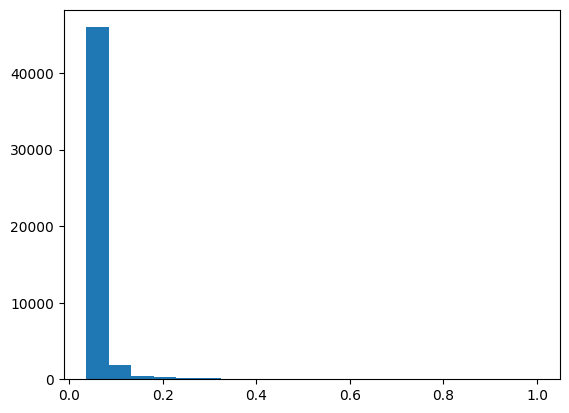

In [36]:
plt.hist(example_weights, bins=20)

In [38]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )

es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/pressure_all_weighted_META.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=example_weights,
         )

Epoch 1/1000

Epoch 1: val_mae improved from inf to 0.04311, saving model to ../../saved_models/pressue_all_weighted_META.h5
96/96 - 1s - loss: 1.6914e-06 - mae: 0.0376 - val_loss: 0.0045 - val_mae: 0.0431 - 1s/epoch - 13ms/step
Epoch 2/1000

Epoch 2: val_mae improved from 0.04311 to 0.04240, saving model to ../../saved_models/pressue_all_weighted_META.h5
96/96 - 1s - loss: 1.6724e-06 - mae: 0.0373 - val_loss: 0.0045 - val_mae: 0.0424 - 557ms/epoch - 6ms/step
Epoch 3/1000

Epoch 3: val_mae did not improve from 0.04240
96/96 - 1s - loss: 1.6589e-06 - mae: 0.0371 - val_loss: 0.0045 - val_mae: 0.0425 - 534ms/epoch - 6ms/step
Epoch 4/1000

Epoch 4: val_mae improved from 0.04240 to 0.04138, saving model to ../../saved_models/pressue_all_weighted_META.h5
96/96 - 1s - loss: 1.6481e-06 - mae: 0.0371 - val_loss: 0.0044 - val_mae: 0.0414 - 556ms/epoch - 6ms/step
Epoch 5/1000

Epoch 5: val_mae did not improve from 0.04138
96/96 - 1s - loss: 1.6419e-06 - mae: 0.0370 - val_loss: 0.0044 - val_mae: 0

Epoch 48/1000

Epoch 48: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.4276e-06 - mae: 0.0348 - val_loss: 0.0051 - val_mae: 0.0464 - 529ms/epoch - 6ms/step
Epoch 49/1000

Epoch 49: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.4155e-06 - mae: 0.0347 - val_loss: 0.0052 - val_mae: 0.0486 - 535ms/epoch - 6ms/step
Epoch 50/1000

Epoch 50: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.4132e-06 - mae: 0.0346 - val_loss: 0.0053 - val_mae: 0.0480 - 536ms/epoch - 6ms/step
Epoch 51/1000

Epoch 51: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.4075e-06 - mae: 0.0345 - val_loss: 0.0057 - val_mae: 0.0515 - 532ms/epoch - 6ms/step
Epoch 52/1000

Epoch 52: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.4022e-06 - mae: 0.0344 - val_loss: 0.0052 - val_mae: 0.0480 - 524ms/epoch - 5ms/step
Epoch 53/1000

Epoch 53: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.3924e-06 - mae: 0.0343 - val_loss: 0.0054 - val_mae: 0.0488 - 528ms/epoch - 6

Epoch 97/1000

Epoch 97: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.3360e-06 - mae: 0.0338 - val_loss: 0.0054 - val_mae: 0.0503 - 533ms/epoch - 6ms/step
Epoch 98/1000

Epoch 98: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.3354e-06 - mae: 0.0338 - val_loss: 0.0051 - val_mae: 0.0491 - 530ms/epoch - 6ms/step
Epoch 99/1000

Epoch 99: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.3345e-06 - mae: 0.0338 - val_loss: 0.0053 - val_mae: 0.0494 - 530ms/epoch - 6ms/step
Epoch 100/1000

Epoch 100: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.3328e-06 - mae: 0.0338 - val_loss: 0.0058 - val_mae: 0.0537 - 530ms/epoch - 6ms/step
Epoch 101/1000

Epoch 101: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.3309e-06 - mae: 0.0338 - val_loss: 0.0053 - val_mae: 0.0507 - 537ms/epoch - 6ms/step
Epoch 102/1000

Epoch 102: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.3393e-06 - mae: 0.0339 - val_loss: 0.0055 - val_mae: 0.0524 - 530ms/epo

96/96 - 1s - loss: 1.3027e-06 - mae: 0.0337 - val_loss: 0.0052 - val_mae: 0.0505 - 533ms/epoch - 6ms/step
Epoch 146/1000

Epoch 146: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2777e-06 - mae: 0.0332 - val_loss: 0.0055 - val_mae: 0.0532 - 531ms/epoch - 6ms/step
Epoch 147/1000

Epoch 147: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2847e-06 - mae: 0.0333 - val_loss: 0.0057 - val_mae: 0.0550 - 530ms/epoch - 6ms/step
Epoch 148/1000

Epoch 148: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2931e-06 - mae: 0.0335 - val_loss: 0.0052 - val_mae: 0.0510 - 529ms/epoch - 6ms/step
Epoch 149/1000

Epoch 149: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2739e-06 - mae: 0.0332 - val_loss: 0.0056 - val_mae: 0.0538 - 528ms/epoch - 6ms/step
Epoch 150/1000

Epoch 150: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2866e-06 - mae: 0.0334 - val_loss: 0.0054 - val_mae: 0.0521 - 528ms/epoch - 5ms/step
Epoch 151/1000

Epoch 151: val_mae did not i

Epoch 194/1000

Epoch 194: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2385e-06 - mae: 0.0329 - val_loss: 0.0065 - val_mae: 0.0603 - 530ms/epoch - 6ms/step
Epoch 195/1000

Epoch 195: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2380e-06 - mae: 0.0329 - val_loss: 0.0062 - val_mae: 0.0570 - 530ms/epoch - 6ms/step
Epoch 196/1000

Epoch 196: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2349e-06 - mae: 0.0329 - val_loss: 0.0066 - val_mae: 0.0610 - 528ms/epoch - 5ms/step
Epoch 197/1000

Epoch 197: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2361e-06 - mae: 0.0329 - val_loss: 0.0064 - val_mae: 0.0592 - 528ms/epoch - 5ms/step
Epoch 198/1000

Epoch 198: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2512e-06 - mae: 0.0331 - val_loss: 0.0068 - val_mae: 0.0615 - 538ms/epoch - 6ms/step
Epoch 199/1000

Epoch 199: val_mae did not improve from 0.04096
96/96 - 1s - loss: 1.2446e-06 - mae: 0.0330 - val_loss: 0.0064 - val_mae: 0.0595 - 536